In [2]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import curve_fit
from math import pi
from scipy.odr import ODR, Model, Data, RealData

In [ ]:
## Counting photons at each sDOM distance from POCAM2 to determine abs/att length
# Check events under peak, and events under entire curve
# number of events is proportional to intensity, which follows (1/r^2)*exp(-r/lambda)

# CORRECTIONS: noise/background, multi-photon events, time window considered, 
#   dead time of the detector (characterized by faulty timestamps), emission angle of POCAM to sDOM

### Terminology and distinctions

Integrating under the peak accounts only for absorption and pure scattering. If any scattering at all occurs, then it (probably) won't occur in the peak. Therefore this calculation will give the pure attenuation length. This is not necessarily an accurate calculation though, because it doesn't account for the varying degree of scattering that can occur, nor does it account for the pulse shape of the source, which in itself has a width in time.

Integrating under the entire curve accounts for absorption and *effective* scattering. Photons that are absorbed or have scattered so much so that they are not detected at all are are accounted for, while photons that reach the detector even though they've scattered along the way are counted. Therefore this calculation will give me the *effective* attenuation length.

In [182]:
## read and clean data for POCAM2 in sDOM order ['5', '1', '2', '3'] 

# Input: data path, time correction array (photon counts are scaled by this amount)
# Output: peak and total photon count
def photon_counter(path, time_correction=[1,1,1,1], dead_time_uncert=[0,0,0,0], remove_indices=[], save_corrections=True):

    path_meas = path
    sDOM_list = ['5', '1', '2', '3'] 
    peak_photons_list = []
    total_photons_list = []
    peak_uncert_list = []
    total_uncert_list = []
    colour = 'uv'

    # corrections
    ang_corr_POCAM = np.array([0.9965713553892441, 0.9824356070523892, 0.9933104593751472, 0.9951019362703488])
    ang_corr_sDOM = np.array([1, .775 ,.86 ,.91]) 
    angle_correction = ang_corr_POCAM*ang_corr_sDOM
    
    # uncertainties (percentage)
    POCAM_uncert = np.array([3, 3.75, 3, 3]) # percent 
    sDOM_QE_uncert = 4.8 # 4.5% for violet, 7% for blue, 4.8% for uv
    sDOM_ang_uncert =  np.array([0, 3.87096774, 2.90697674, 1.0989011 ]) # percent

    for index,DOM_num in enumerate(sDOM_list):
        
        # skip selected DOMs
        if index in remove_indices:
            peak_photons_list = np.append(peak_photons_list,1) # arbitrary placeholder value
            total_photons_list = np.append(total_photons_list,1)
            peak_uncert_list = np.append(peak_uncert_list,0)
            total_uncert_list = np.append(total_uncert_list,0)
            continue

        # Get measurement data
        file = "['P2'],['SDOM%s'],up,%s,['20V'],['2500Hz'].csv"%(DOM_num,colour)
        my_data = np.genfromtxt(path_meas+file, delimiter=',')
        times = my_data[0][:]
        counts = my_data[1][:]

        # Apply corrections
        #time_interval = (times[-1] - times[0])/len(times) # 1ns
        noise = np.mean(counts[0:80]) # time -100 to -20 ns

        counts_bkg_removed = np.array([max(0.001,hits-noise) for hits in counts])

        counts_time_corrected = counts_bkg_removed/time_correction[index]

        counts_angle_corrected = counts_time_corrected/angle_correction[index]

        counts_peak = np.sum(counts_angle_corrected[(times>-10) & (times<10)])
        counts_total = np.sum(counts_angle_corrected)

        peak_photons_list = np.append(peak_photons_list,counts_peak)
        total_photons_list = np.append(total_photons_list,counts_total)
        
        # Save corrections
        if save_corrections:
            file = "['P2'],['SDOM%s'],up,%s,['20V'],['2500Hz'],corrected.csv"%(DOM_num,colour)
            with open(path_meas+file, 'w') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(times)
                writer.writerow(counts_angle_corrected)
            csvfile.close()
            
        # Calculate uncertainty
        poisson_err_peak = np.sqrt(counts_peak)/counts_peak*100 # percent error according to poisson distribution
        poisson_err_total = np.sqrt(counts_total)/counts_total*100
        
        peak_uncertainty = np.sqrt(poisson_err_peak**2 + POCAM_uncert[index]**2 + sDOM_QE_uncert**2 + 
                                   sDOM_ang_uncert[index]**2 + dead_time_uncert[index]**2)
        total_uncertainty = np.sqrt(poisson_err_total**2 + POCAM_uncert[index]**2 + sDOM_QE_uncert**2 + 
                                   sDOM_ang_uncert[index]**2 + dead_time_uncert[index]**2)
        peak_uncert_list = np.append(peak_uncert_list,peak_uncertainty)
        total_uncert_list = np.append(total_uncert_list,total_uncertainty)

    print('sDOM_list:     ', sDOM_list)
    print('peak_photons:  ', peak_photons_list)
    print('total_photons: ', total_photons_list)
    print('peak_photons_uncert:  ', peak_uncert_list)
    print('total_photons_uncert: ', total_uncert_list)
    
    return peak_photons_list, total_photons_list, peak_uncert_list, total_uncert_list




In [15]:
## Plot results and determine attenuation length

def lin_fit(x, slope, y_int):
    return slope*x + y_int

def attenuation_length(path, peak_photons, total_photons, peak_uncertainty=0, total_uncertainty=0, remove_indices=[]):

    sDOM_list = ['5', '1', '2', '3'] 
    sDOM_dist_list = np.array([38.56,52.94,69.02, 86.04]) # m
    sDOM_dist_uncert = np.array([5.2, 2.7, 2.5, 2.1]) # percent

    y_peak_photons = np.log(peak_photons*np.power(sDOM_dist_list,2))
    y_all_photons = np.log(total_photons*np.power(sDOM_dist_list,2))
    
    # absolute uncertainties
    y_peak_err = np.sqrt(np.power(peak_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
    y_all_err = np.sqrt(np.power(total_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
    x_err = sDOM_dist_uncert/100*sDOM_dist_list
    
    # remove indices
    #sDOM_list = np.delete(sDOM_list,remove_indices)
    #sDOM_dist_list = np.delete(sDOM_dist_list,remove_indices)
    #sDOM_dist_uncert = np.delete(sDOM_dist_uncert,remove_indices)
    #y_peak_photons = np.delete(y_peak_photons,remove_indices)
    #y_all_photons = np.delete(y_all_photons,remove_indices)
    #y_peak_err = np.delete(y_peak_err,remove_indices)
    #y_all_err = np.delete(y_all_err,remove_indices)
    #x_err = np.delete(x_err,remove_indices)
    
    # fit with uncertainty
    p0 = np.array([-1/14, 22])
    popt_peak, pcov_peak = curve_fit(lin_fit, sDOM_dist_list[1:], y_peak_photons[1:], p0, y_peak_err[1:], absolute_sigma=True)
    att_len = -1/popt_peak[0]
    perr = np.sqrt(np.diag(pcov_peak))
    att_len_err = abs(perr[0]/popt_peak[0])*att_len
    
    popt_all, pcov_all = curve_fit(lin_fit, sDOM_dist_list[1:], y_all_photons[1:], p0, y_all_err[1:], absolute_sigma=True)
    eff_att_len = -1/popt_all[0]
    perr = np.sqrt(np.diag(pcov_all))
    eff_att_len_err = abs(perr[0]/popt_all[0])*eff_att_len

    x_fit = np.linspace(35,90)
    y_fit_peak = np.polyval(popt_peak,x_fit)
    y_fit_all = np.polyval(popt_all,x_fit)
    
    print('attenuation length: %.1f +/- %.1f'%(att_len,att_len_err), 'm' )
    print('effective attenuation length: %.1f +/- %.1f'%(eff_att_len,eff_att_len_err), 'm')

    # plot ln(num_photons*r^2) vs r
    fig, ax = plt.subplots(figsize=(10,9))
    ax.errorbar(sDOM_dist_list,y_all_photons, xerr=x_err, yerr=y_all_err ,marker='.',linestyle='')
    ax.plot(x_fit,y_fit_all,color='k',label='eff_att_len = %.1f'%eff_att_len)
    ax.errorbar(sDOM_dist_list,y_peak_photons, xerr=x_err, yerr=y_peak_err, marker='.',linestyle='')
    ax.plot(x_fit,y_fit_peak,color='k',label='att_len = %.1f'%att_len,linestyle='--')
    ax.set_title('Attenuation length')
    ax.set_ylabel('ln(num_photons * r^2)')
    ax.set_xlabel('r (m)')
    ax.legend()
    plt.savefig(path+'attenuation_length.png',bbox_inches='tight')
    
    return att_len, eff_att_len




In [196]:
## Attenuation, scattering, and absorption
## just for checking and verifying parameters

# Input parameters
eta = 0.104
scatt_len = 10.6
abs_len = 30.5

avg_cos = (1-eta)*0.924 #average cosine of the scattering angle
eff_scatt = scatt_len/(1-avg_cos)
print('eff_scatt: ', eff_scatt)

eff_att_len_theoretical = 1 / (1/eff_scatt + 1/abs_len)
att_len_theor = 1 / (1/scatt_len + 1/abs_len)
print('eff_att_len: ',eff_att_len_theoretical)
print('att_len: ',att_len_theor)

print('avg_cos: ',avg_cos)



eff_scatt:  61.59352919300858
eff_att_len:  20.398855998336295
att_len:  7.8661800486618
avg_cos:  0.8279040000000001


## POSEIDON violet

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [220257.19561978  58839.66540357  10973.89303442   2260.75019152]
total_photons:  [256168.7845273   83578.22987403  17486.31915961   4407.19008081]
peak_photons_uncert:   [5.66439771 7.24130893 6.47834829 6.33263189]
total_photons_uncert:  [5.66383587 7.23783463 6.45210187 6.16018957]
attenuation length: 14.5 +/- 0.7 m
effective attenuation length: 16.9 +/- 0.9 m


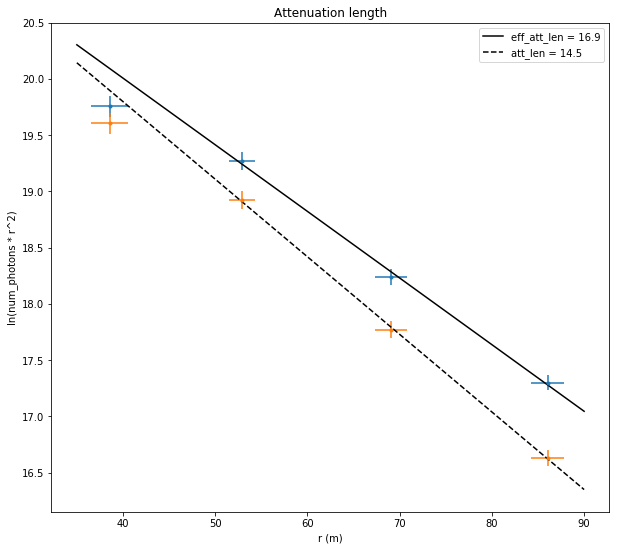

In [105]:
path_meas = "Data/POSEIDON1/violet/Measured_arrival_times/"
path_save = "Data/POSEIDON1/violet/Optimization/"
#time_correction = np.array([0.995796629945324, 0.9683631088988357, 0.57504120677826, 0.3756827648418125])
time_correction = np.array([1.0144305079415528, 0.9885799387876817, 0.57504120677826, 0.3756827648418125])
dead_time_uncert = np.array([0, 0.42392268563089913, 0.7531461586286848, 1.5592730733224076])

peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction, dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)




## SANTACLAUS violet

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [202324.54897446  92208.55503571  17866.21736829   2523.21049416]
total_photons:  [245275.89688199 119696.16729081  27605.91741768   5001.31765171]
peak_photons_uncert:   [5.66475291 7.22463432 6.40704529 6.10006463]
total_photons_uncert:  [5.66398891 7.2229105  6.39161599 5.93692317]
attenuation length: 12.5 +/- 0.5 m
effective attenuation length: 14.9 +/- 0.7 m


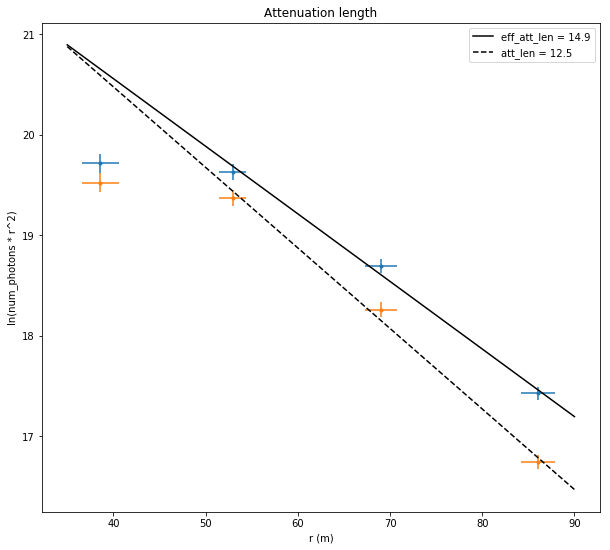

In [107]:
path_meas = "Data/SANTACLAUS/violet/Measured_arrival_times/"
path_save = "Data/SANTACLAUS/violet/Optimization/"
time_correction = [1,1,1,1]
dead_time_uncert = np.array([0, 0, 0, 0])
peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)

## MINOS violet

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [116660.12308771  29462.81528031   5574.54892343   1391.96100986]
total_photons:  [131717.28293076  41308.67528209   8694.62818474   2593.72054206]
peak_photons_uncert:   [5.66795546 7.2617432  6.56944893 6.35859205]
total_photons_uncert:  [5.66709098 7.25503848 6.52027051 6.09122722]
attenuation length: 16.0 +/- 0.8 m
effective attenuation length: 18.7 +/- 1.1 m


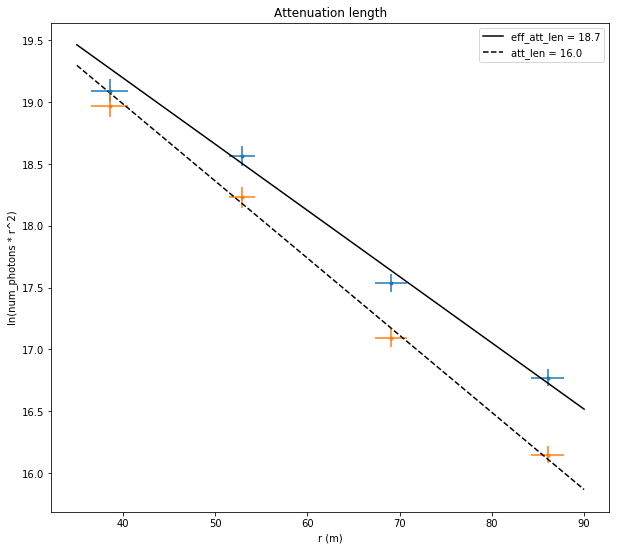

In [175]:
path_meas = "Data/MINOS1/violet/Measured_arrival_times/"
path_save = "Data/MINOS1/violet/Optimization/"
#time_correction = [1.0285466549469098, 0.987763674488849, 0.9287033009593826, 1.028556404163802]
time_correction = [1.0285466549469098, 0.8286509010010416, .6, 1.028556404163802]
dead_time_uncert = np.array([0,  0.5537257657080588 , 0.9344936471196127, 0])
peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction,dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)



## HERA violet

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [211410.71004301  66760.95453806  11896.03187296   2650.75927164]
total_photons:  [243757.91097004  94529.46760481  20830.27508185   4939.31132138]
peak_photons_uncert:   [5.70103982 7.23739338 6.43171054 6.11255965]
total_photons_uncert:  [5.70048928 7.2343529  6.40362042 5.96786857]
attenuation length: 14.8 +/- 0.7 m
effective attenuation length: 16.7 +/- 0.9 m


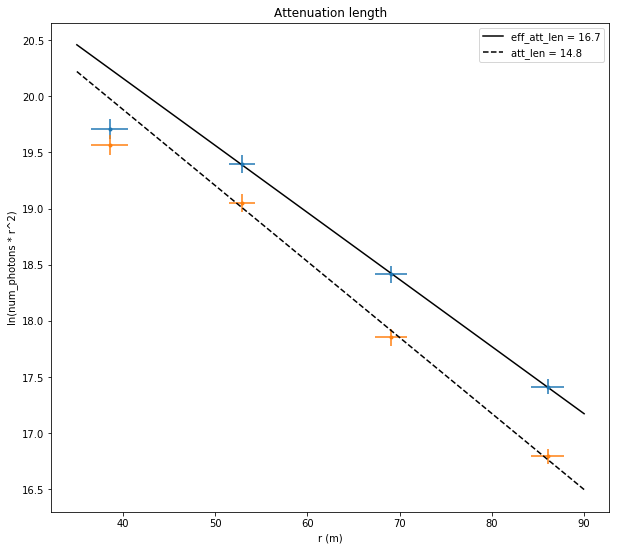

In [176]:
path_meas = "Data/HERA1/violet/Measured_arrival_times/"
path_save = "Data/HERA1/violet/Optimization/"
time_correction = [0.972667504074096, 0.987701636676303, 1.009670741366335, 0.5401133276607534]
dead_time_uncert = np.array([0.6438584934203984, 0.3783960654156056, 0.1891301571131311, 0.5859162783496578])
peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction,dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)


## MINOS uv - signal only visible for sDOMs 1 & 5 

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [6.04018558e+03 1.00873500e+03 1.00000000e+00 1.00000000e+00]
total_photons:  [9.20171376e+03 1.97754847e+03 1.00000000e+00 1.00000000e+00]
peak_photons_uncert:   [5.90149336 7.89036998 0.         0.        ]
total_photons_uncert:  [5.85310171 7.57636444 0.         0.        ]
attenuation length: 13.7 +/- 0.4 m
effective attenuation length: 11.5 +/- 0.3 m


FileNotFoundError: [Errno 2] No such file or directory: 'Data/MINOS1/uv/Optimization/attenuation_length.png'

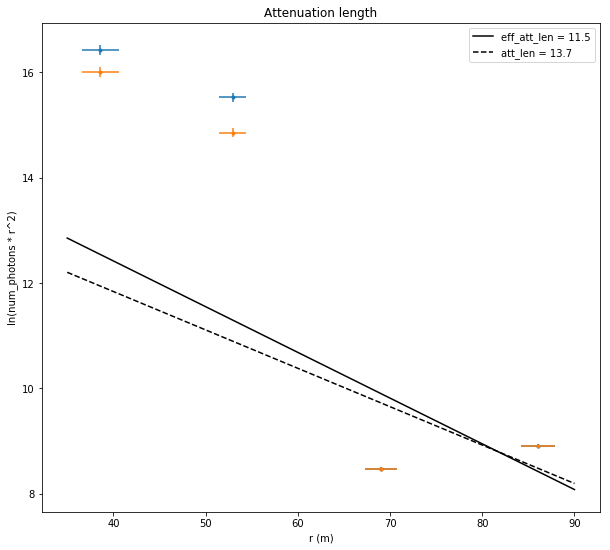

In [183]:
path_meas = "Data/MINOS1/uv/Measured_arrival_times/"
path_save = "Data/MINOS1/uv/Optimization/"
time_correction = [0.6080948809144353, 0.7290489109472654, 1, 1]
dead_time_uncert = np.array([1.0639763145950287, 0.5075832685674216, 0, 0])
remove_indices = np.array([2,3])
peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction,dead_time_uncert,remove_indices)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty,remove_indices)



## HERA uv - signal only visible for sDOMs 1 & 5 

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [1.27323347e+04 2.61952679e+03 1.00000000e+00 1.00000000e+00]
total_photons:  [1.97395146e+04 4.79309454e+03 1.00000000e+00 1.00000000e+00]
peak_photons_uncert:   [5.72934568 7.50142288 0.         0.        ]
total_photons_uncert:  [5.70496258 7.38513349 0.         0.        ]
attenuation length: 10.8 +/- 0.2 m
effective attenuation length: 9.7 +/- 0.2 m


FileNotFoundError: [Errno 2] No such file or directory: 'Data/HERA1/uv/Optimization/attenuation_length.png'

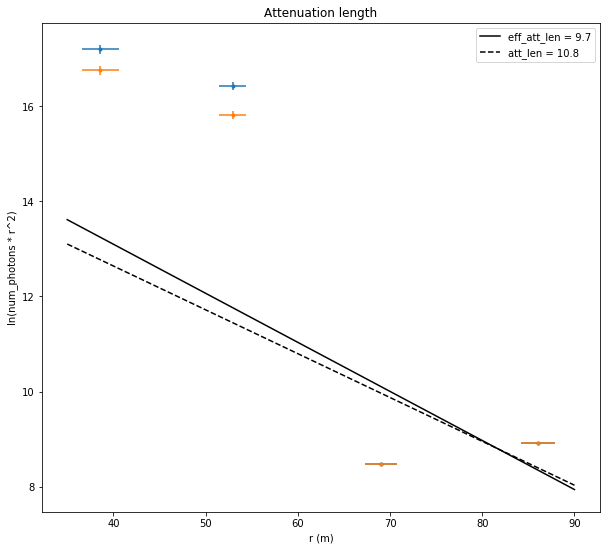

In [184]:
path_meas = "Data/HERA1/uv/Measured_arrival_times/"
path_save = "Data/HERA1/uv/Optimization/"
time_correction = [1.014346050925423, 0.717807870604021, 1, 1]
dead_time_uncert = np.array([0, 0.6057809780986867, 0, 0])
remove_indices = np.array([2,3])
peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction,dead_time_uncert,remove_indices)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty,remove_indices)

In [368]:
## Testing curve fitting with sigma on y only

def lin_fit(x, slope, y_int):
    return slope*x + y_int

sDOM_list = ['5', '1', '2', '3'] 
sDOM_dist_list = np.array([38.56,52.94,69.02, 86.04]) # m
sDOM_dist_uncert = np.array([5.2, 2.7, 2.5, 2.1]) # percent

peak_photons = np.array([220257.73456993,  58840.9646608,  10977.02145368,  2266.33519394])
total_photons = np.array([256180.91356772,  83608.378972,    17522.2134148,    4462.12298885])

peak_photons_uncert = np.array([5.41252264, 7.04603089, 6.25929204, 6.10748116])
total_photons_uncert = np.array([5.41193449, 7.04245745, 6.23204999, 5.92705676])

y_peak_photons = np.log(peak_photons*np.power(sDOM_dist_list,2))
y_all_photons = np.log(total_photons*np.power(sDOM_dist_list,2))

# absolute uncertainties
y_peak_err = np.sqrt(np.power(peak_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
y_all_err = np.sqrt(np.power(total_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
x_err = sDOM_dist_uncert/100*sDOM_dist_list

p0 = np.array([-1/14, 22])
popt_peak, pcov_peak = curve_fit(lin_fit, sDOM_dist_list[1:], y_peak_photons[1:], p0, y_peak_err[1:], absolute_sigma=True)
att_len = -1/popt_peak[0]
perr = np.sqrt(np.diag(pcov_peak))
att_len_err = abs(perr[0]/popt_peak[0])*att_len

print('attenuation length: %.1f +/- %.1f'%(att_len,att_len_err), 'm' )
print('percent_error: ', abs(perr[0]/popt_peak[0])*100)



attenuation length: 14.5 +/- 0.7 m
percent_error:  4.504132755622445


In [211]:
v_dist = 37.87#77.68
percent_uncert = (2/v_dist)*2*(v_dist**2)/(v_dist**2+37**2)/2
print(percent_uncert)

0.027019729218362473


In [349]:
## Testing ODR package to get fit with sigma on x and y
# I found that including sx on top of sy doesn't increase the uncertainty estimate (when sigma values are relative). 
# So I will continue to use curve_fit with absolute_sigma=True, as this gives a seemingly more reasonable uncertainty

def f(B, x):
    return B[0]*x + B[1]

#print(x_err, y_peak_err)

sx = x_err/sDOM_dist_list
sy = y_peak_err/y_peak_photons

data = RealData(sDOM_dist_list[1:],y_peak_photons[1:],sx=sx[1:],sy=sy[1:])
linear = Model(f)

odr = ODR(data, linear, beta0=[-1/14, 22])
output = odr.run()

output.pprint()

slope = output.beta[0]
slope_std = output.sd_beta[0]

att_len = -1/slope
att_len_err = abs(slope_std/slope)*att_len
print('attenuation length: %f +/- %f'%(att_len,att_len_err), 'm')


Beta: [-0.06897381 22.55811354]
Beta Std Error: [0.00135056 0.0963302 ]
Beta Covariance: [[ 3.65356577e-08 -2.55932110e-06]
 [-2.55932110e-06  1.85871214e-04]]
Residual Variance: 49.92438813947543
Inverse Condition #: 0.0367433067460529
Reason(s) for Halting:
  Sum of squares convergence
attenuation length: 14.498257 +/- 0.283888 m


# POSEIDON blue (12V)

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [183353.2320825   74101.36856881  23352.4983533    7065.56478731]
total_photons:  [210001.81500934  92686.5269114   33276.99052821  10920.38405225]
peak_photons_uncert:   [5.66520428 7.4276141  6.39678067 6.030106  ]
total_photons_uncert:  [5.66459342 7.42579232 6.38679037 5.98853756]
attenuation length: 23.9 +/- 1.8 m
effective attenuation length: 28.1 +/- 2.5 m


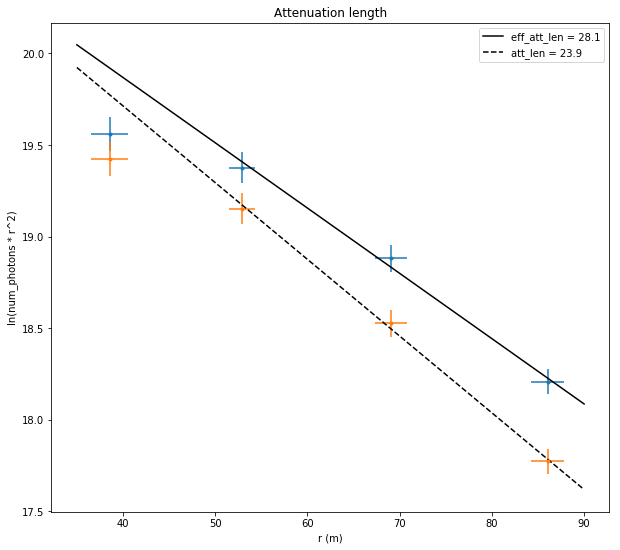

In [179]:
path_meas = "Data/POSEIDON1/blue/Measured_arrival_times/"
path_save = "Data/POSEIDON1/blue/Optimization/"
time_correction = np.array([1.0144305079415528, 0.7039617433301677, 1.014049638713966, 0.3166666666666667])#0.49294503306476334])
#time_correction = np.array([1.0144305079415528, 0.520925480298619, 1.014049638713966, 0.337482193960288])
dead_time_uncert = np.array([0, 1.71686043202065, 0.008334891249822788, 1.303564237783164])

peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction, dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)




# MINOS blue (12V)

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [94568.63975651 45309.38014416 12377.13409126  4072.49047569]
total_photons:  [108272.33979773  55203.65908286  16560.01247235   5872.58432894]
peak_photons_uncert:   [5.66972162 7.23260978 6.47261542 5.99057143]
total_photons_uncert:  [5.66854123 7.22987461 6.45683151 5.92741714]
attenuation length: 23.2 +/- 1.7 m
effective attenuation length: 26.3 +/- 2.2 m


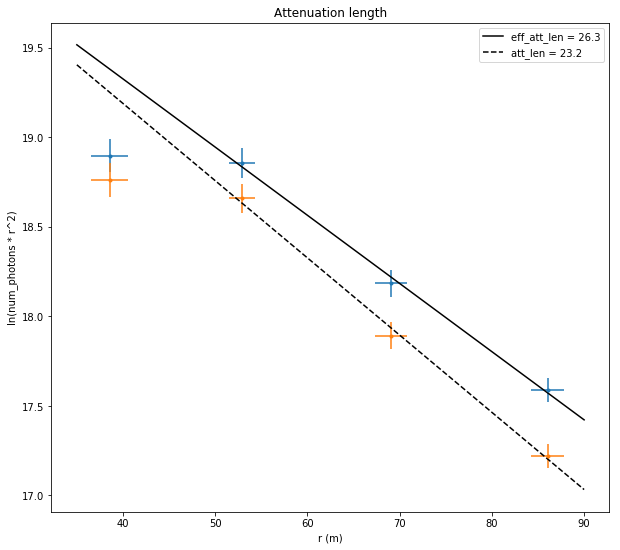

In [180]:
path_meas = "Data/MINOS1/blue/Measured_arrival_times/"
path_save = "Data/MINOS1/blue/Optimization/"
#time_correction = np.array([1.028349722332878, 1.027723462282227, 1.010574720942054, 0.945353328924711])
time_correction = np.array([1.028349722332878, .8, 1.010574720942054, 0.945353328924711])
dead_time_uncert = np.array([0, 0.055210512264143474, 0.7722014589578418, 0.4287918613237877])

peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction, dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)




# HERA blue (12V)

sDOM_list:      ['5', '1', '2', '3']
peak_photons:   [188719.04671895  93955.03896973  29723.44668778   8789.76539261]
total_photons:  [210698.19058953 115544.1766137   39026.39715939  12004.99814313]
peak_photons_uncert:   [5.66571721 7.24220826 6.3895969  5.89414996]
total_photons_uncert:  [5.66522938 7.24083514 6.38331815 5.86824534]
attenuation length: 23.5 +/- 1.7 m
effective attenuation length: 25.4 +/- 2.0 m


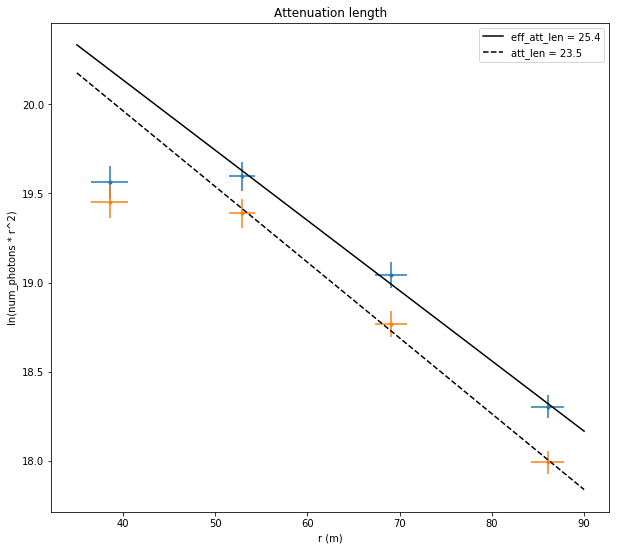

In [181]:
path_meas = "Data/HERA1/blue/Measured_arrival_times/"
path_save = "Data/HERA1/blue/Optimization/"
#time_correction = np.array([1.013179813443364, 0.990187866658942, 1.014078616866683, 0.8642697673644203])
time_correction = np.array([1.013179813443364, 0.7140547253133788, 1.014078616866683, 0.8642697673644203])
dead_time_uncert = np.array([0.08580605057250545, 0.5062167089540252, 0, 0.5964338558812285])

peak_photons, total_photons, peak_uncertainty, total_uncertainty = photon_counter(path_meas, time_correction, dead_time_uncert)
att_len, eff_att_len = attenuation_length(path_save, peak_photons, total_photons, peak_uncertainty, total_uncertainty)




In [13]:
def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m

In [59]:
sDOM_list= ['5', '1', '2', '3'] 
# HERA
#peak_photons= np.array([1.27303031e+04 , 2.61799305e+03, 1.00000000e+00, 1.00000000e+00])
#total_photons=np.array([1.96971040e+04, 4.77440012e+03, 1.00000000e+00, 1.00000000e+00])
#peak_photons_uncert= np.array([5.72935662, 7.50157195, 0., 0.])
#total_photons_uncert=np.array([5.70505818, 7.38568655, 0., 0.])
#MINOS
peak_photons= np.array([6.03624345e+03 ,1.00891118e+03, 1.00000000e+00, 1.00000000e+00])
total_photons=np.array([9.15593602e+03, 1.97933355e+03 , 1.00000000e+00, 1.00000000e+00])
peak_photons_uncert= np.array([5.90158496, 7.89026028, 0., 0.])
total_photons_uncert=np.array([5.85356586, 7.57606346, 0., 0.])

sDOM_dist_list = np.array([38.56,52.94,69.02, 86.04]) # m
sDOM_dist_uncert = np.array([5.2, 2.7, 2.5, 2.1]) # percent

y_peak_photons = np.log(peak_photons*np.power(sDOM_dist_list,2))
y_all_photons = np.log(total_photons*np.power(sDOM_dist_list,2))
    
# absolute uncertainties
y_peak_err = np.sqrt(np.power(peak_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
y_all_err = np.sqrt(np.power(total_uncertainty,2)+2*np.power(sDOM_dist_uncert,2))/100
x_err = sDOM_dist_uncert/100*sDOM_dist_list

m_peak = slope(sDOM_dist_list[0],y_peak_photons[0],sDOM_dist_list[1],y_peak_photons[1])
m_peak_max = slope(sDOM_dist_list[0],y_peak_photons[0]+y_peak_err[0],sDOM_dist_list[1],y_peak_photons[1]-y_peak_err[1])
m_peak_min = slope(sDOM_dist_list[0],y_peak_photons[0]-y_peak_err[0],sDOM_dist_list[1],y_peak_photons[1]+y_peak_err[1])
m_peak_uncer = abs((m_peak_max-m_peak_min)/2/m_peak)

m_all = slope(sDOM_dist_list[0],y_all_photons[0],sDOM_dist_list[1],y_all_photons[1])
m_all_max = slope(sDOM_dist_list[0],y_all_photons[0]+y_all_err[0],sDOM_dist_list[1],y_peak_photons[1]-y_all_err[1])
m_all_min = slope(sDOM_dist_list[0],y_all_photons[0]-y_all_err[0],sDOM_dist_list[1],y_peak_photons[1]+y_all_err[1])
m_all_uncer = abs((m_all_max-m_all_min)/2/m_all)

att_len = -1/m_peak
eff_att_len = -1/m_all
print(att_len, m_peak_uncer*att_len)
print(eff_att_len, m_all_uncer*eff_att_len)




12.449971662921607 1.961211159526249
16.01773735088969 3.1906970497495353


In [66]:
## Effective scattering length uncertainty
# Input: eta, scatt_len, and respective uncertainties
# Output: eff_scatt_len and uncertainty

def eff_sct_len(eta,scatt_len,d_eta,d_scatt_len):
    avg_cos = (1-eta)*0.924
    d_avg_cos = d_eta*.924
    
    eff_scatt = scatt_len/(1-avg_cos)
    d_eff_scatt = np.sqrt((d_scatt_len/scatt_len)**2 + (d_avg_cos/(1-avg_cos))**2) * eff_scatt
    
    return eff_scatt, d_eff_scatt
    


In [79]:
eff_scatt, d_eff_scatt = eff_sct_len(.62,19.4,.04,3)
print('%.1f'%eff_scatt,'+/-', '%.1f'%d_eff_scatt)

29.9 +/- 4.9


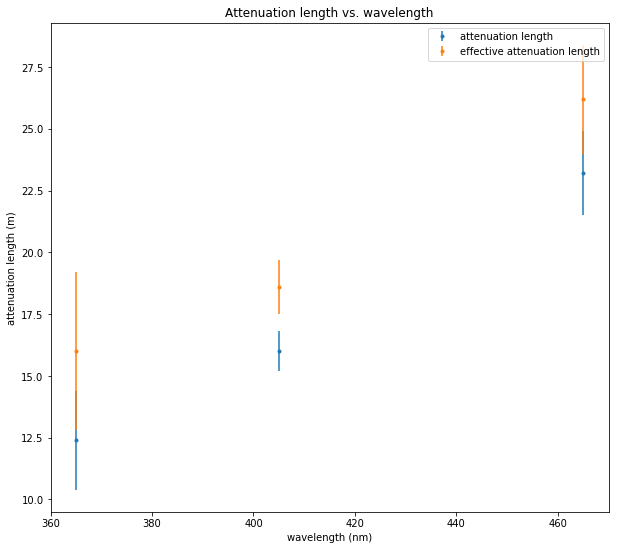

In [6]:
## Attenuation length vs wavelength

path = "Data/MINOS1/violet/Optimization/"

wavelength = [365, 405, 465]
att_len_vs_lambda = [12.4, 16, 23.2]
att_len_vs_lambda_uncert = [2, .8, 1.7]

eff_att_len_vs_lambda = [16, 18.6, 26.2]
eff_att_len_vs_lambda_uncert = [3.2, 1.1, 2.2]

#att_len_vs_lambda = [15.2, 14.8, 23.5]
#att_len_vs_lambda_uncert = [2.8,.7,1.7]

#eff_att_len_vs_lambda = [18.4,16.7,25.4]
#eff_att_len_vs_lambda_uncert = [4.1,.9,2]

fig, ax = plt.subplots(figsize=(10,9))
ax.errorbar(wavelength,att_len_vs_lambda, yerr=att_len_vs_lambda_uncert ,marker='.',linestyle='', label='attenuation length')
ax.errorbar(wavelength,eff_att_len_vs_lambda, yerr=eff_att_len_vs_lambda_uncert ,marker='.',linestyle='', label='effective attenuation length')
ax.set_title('Attenuation length vs. wavelength')
ax.set_ylabel('attenuation length (m)')
ax.set_xlabel('wavelength (nm)')
ax.legend()
plt.savefig(path+'attenuation_length_vs_wavelength_Mar_2019.png',bbox_inches='tight')
    

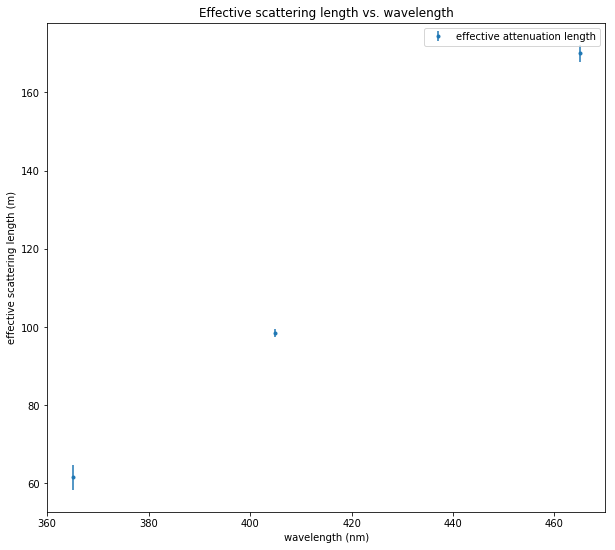

In [197]:
## Effective scattering length vs wavelength

path = "Data/MINOS1/violet/Optimization/"

wavelength = [365, 405, 465]
eff_sct_len_vs_lambda_1 = [61.6, 98.5, 170]
eff_sct_len_vs_lambda_uncert = [3.2, 1.1, 2.2]

fig, ax = plt.subplots(figsize=(10,9))
ax.errorbar(wavelength,eff_sct_len_vs_lambda, yerr=eff_sct_len_vs_lambda_uncert ,marker='.',linestyle='')
ax.set_title('Effective scattering length vs. wavelength')
ax.set_ylabel('effective scattering length (m)')
ax.set_xlabel('wavelength (nm)')
ax.legend()
#plt.savefig(path+'attenuation_length_vs_wavelength_Mar_2019.png',bbox_inches='tight')



Text(0.5,0,'wavelength (nm)')

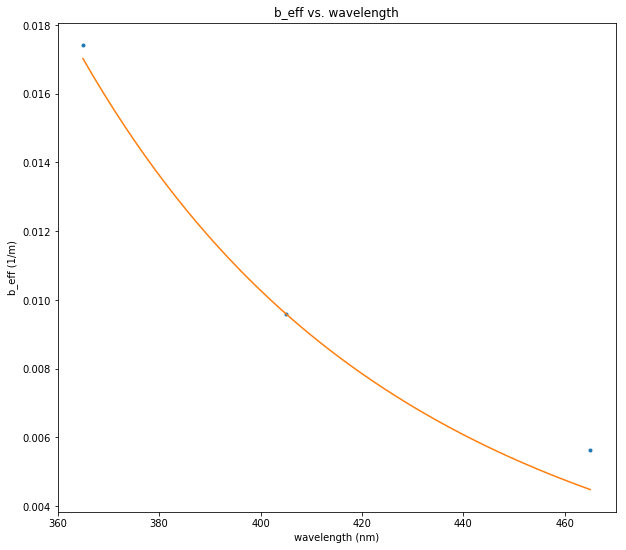

In [209]:
## Effective scattering length vs wavelength

path = "Data/MINOS1/violet/Optimization/"

wavelength = [365, 405, 465]
#b_eff_vs_lambda = 1/np.array([61.6, 98.5, 170])
b_eff_vs_lambda = 1/np.array([57.4, 104.2, 177.6])
#eff_sct_len_vs_lambda_uncert = [3.2, 1.1, 2.2]

#x = np.linspace(365,465)
#y = power_law(x,5.5096447)

fig, ax = plt.subplots(figsize=(10,9))
ax.plot(wavelength,b_eff_vs_lambda ,marker='.',linestyle='', label='')
#ax.plot(x,y)
ax.set_title('b_eff vs. wavelength')
ax.set_ylabel('b_eff (1/m)')
ax.set_xlabel('wavelength (nm)')
#plt.savefig(path+'attenuation_length_vs_wavelength_Mar_2019.png',bbox_inches='tight')

In [207]:
## effective scattering length (1/m) vs. wavelength (nm), wrt values at violet 405nm
def power_law(x,k):
    b_eff = (1/104.2)*np.power((x/405),-k)
    return b_eff

In [208]:
wavelength = np.array([365, 405, 465])
b_eff_vs_lambda = 1/np.array([57.4, 104.2, 177.6])

p0 = [3.5]
popt,pcov = curve_fit(power_law, wavelength, b_eff_vs_lambda, p0)
print(popt)

[5.5096447]


In [224]:
## effective scattering length statistical uncertainties

scatt_len = 25.8
d_scatt_len = .3
dp_scatt_len = d_scatt_len/scatt_len

eta = .188
d_eta = .003

avg_cos = (1-eta)*0.924 #average cosine of the scattering angle
d_avg_cos = d_eta*.924

eff_scatt = scatt_len/(1-avg_cos)
dp_denominator = d_avg_cos/(1-avg_cos)
d_eff_scatt = np.sqrt(np.power(dp_scatt_len,2) + np.power(dp_denominator,2))*eff_scatt

print(eff_scatt)
print(d_eff_scatt)

103.31902351508941
1.660950006398314
